<a href="https://colab.research.google.com/github/sidc124/Alzhimer-Detection/blob/main/EEG_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's vs. Dementia EEG Classification — End-to-End Deep Learning Pipeline

This notebook implements the full pipeline you described:
1) **Find common channels** across OpenNeuro datasets and align them  
2) **Preprocess** (filtering, referencing, resampling)  
3) **Segment** signals into fixed-size windows and **standardize shapes** (pad/crop)  
4) **Build datasets** and loaders for train/val/test (subject-wise splits)  
5) **Train baselines** (EEGNet) and a **custom hybrid model** that aims to outperform EEGNet  
6) **Evaluate & cross-test** across datasets (train on one, test on the other)  
7) **Result analysis** with metrics and confusion matrices

## 1. Setup & Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/EEG_Project/dataset_2/sub-hc1/ses-hc/eeg"
import glob
import os

# Base directory in Google Drive
base_path = "/content/drive/MyDrive/EEG_Project"

# Find all .set and .bdf files
set_files = glob.glob(os.path.join(base_path, "**", "*.set"), recursive=True)
bdf_files = glob.glob(os.path.join(base_path, "**", "*.bdf"), recursive=True)

print(f"Found {len(set_files)} .set files")
print(f"Found {len(bdf_files)} .bdf files")

# Check a few results
print("Example .set file:", set_files[0] if set_files else "None found")
print("Example .bdf file:", bdf_files[0] if bdf_files else "None found")


Mounted at /content/drive
sub-hc1_ses-hc_task-rest_channels.tsv  sub-hc1_ses-hc_task-rest_eeg.json
sub-hc1_ses-hc_task-rest_eeg.bdf       sub-hc1_ses-hc_task-rest_events.tsv
Found 88 .set files
Found 45 .bdf files
Example .set file: /content/drive/MyDrive/EEG_Project/dataset_1/sub-005/eeg/sub-005_task-eyesclosed_eeg.set
Example .bdf file: /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf


## 2. Channels finding and common channels

In [6]:

!pip install mne
import mne

# Pick one file from each dataset
sample_set_file = set_files[0]
sample_bdf_file = bdf_files[0]

# Load raw data without preprocessing
raw_set = mne.io.read_raw_eeglab(sample_set_file, preload=False)
raw_bdf = mne.io.read_raw_bdf(sample_bdf_file, preload=False)

# Get channel names
channels_set = raw_set.info["ch_names"]
channels_bdf = raw_bdf.info["ch_names"]

print("Channels in .set dataset:", channels_set)
print("Channels in .bdf dataset:", channels_bdf)

# Find common channels
common_channels = list(set(channels_set).intersection(set(channels_bdf)))
print(f"Number of common channels: {len(common_channels)}")
print("Common channels:", common_channels)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 89.8 MB/s eta 0:00:00


/tmp/ipython-input-1621918465.py:9: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_set = mne.io.read_raw_eeglab(sample_set_file, preload=False)


Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Channels in .set dataset: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
Channels in .bdf dataset: ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']
Number of common channels: 15
Common channels: ['F4', 'F3', 'C3', 'Fz', 'F7', 'Fp2', 'O2', 'C4', 'O1', 'P3', 'Cz', 'Fp1', 'Pz', 'F8', 'P4']


## 3. reordering the dataset


In [7]:
import mne

# We will use the order from the .set dataset
ordered_common_channels = [ch for ch in channels_set if ch in common_channels]

print("Final channel order:", ordered_common_channels)

# Function to load and reorder channels
def load_and_reorder(filepath, filetype, channel_order):
    if filetype == "set":
        raw = mne.io.read_raw_eeglab(filepath, preload=True)
    elif filetype == "bdf":
        raw = mne.io.read_raw_bdf(filepath, preload=True)
    else:
        raise ValueError("Unsupported file type")

    # Pick only common channels and reorder
    raw.pick_channels(channel_order)
    raw.reorder_channels(channel_order)

    return raw

# Load all .set files in same channel order
all_set_data = [load_and_reorder(f, "set", ordered_common_channels) for f in set_files]

# Load all .bdf files in same channel order
all_bdf_data = [load_and_reorder(f, "bdf", ordered_common_channels) for f in bdf_files]


Final channel order: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc7/ses-hc/eeg/sub-hc7_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...


/tmp/ipython-input-1251132072.py:11: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(filepath, preload=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc1/ses-hc/eeg/sub-hc1_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 98303  =      0.000 ...   191.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc2/ses-hc/eeg/sub-hc2_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 99327  =      0.000 ...   193.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/dataset_2/sub-hc21/ses-hc/eeg/sub-hc21_ses-hc_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Read

## 4. checking if the order is same or not


In [8]:
# Check first 3 files from each dataset to verify channel order
for i, raw_obj in enumerate(all_set_data[:3]):
    print(f"\nSET file {i+1} channels:")
    print(raw_obj.info["ch_names"])

for i, raw_obj in enumerate(all_bdf_data[:3]):
    print(f"\nBDF file {i+1} channels:")
    print(raw_obj.info["ch_names"])

# Final check: compare channel order between first SET and first BDF
set_order = all_set_data[0].info["ch_names"]
bdf_order = all_bdf_data[0].info["ch_names"]

if set_order == bdf_order:
    print("\n✅ Channel orders match for SET and BDF datasets.")
else:
    print("\n❌ Channel orders do NOT match.")
    print("SET order:", set_order)
    print("BDF order:", bdf_order)



SET file 1 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 2 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

SET file 3 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 1 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 2 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

BDF file 3 channels:
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz']

✅ Channel orders match for SET and BDF datasets.


##5. checking the sampling freuquency

## 6. Resampling

In [9]:
target_sfreq = 256 # Hz

# Resample .set files
for i, raw in enumerate(all_set_data):
    if raw.info['sfreq'] != target_sfreq:
        raw.resample(target_sfreq)
        print(f"Resampled .set file {i+1} to {target_sfreq} Hz")

# Resample .bdf files
for i, raw in enumerate(all_bdf_data):
    if raw.info['sfreq'] != target_sfreq:
        raw.resample(target_sfreq)
        print(f"Resampled .bdf file {i+1} to {target_sfreq} Hz")


Resampled .set file 1 to 256 Hz
Resampled .set file 2 to 256 Hz
Resampled .set file 3 to 256 Hz
Resampled .set file 4 to 256 Hz
Resampled .set file 5 to 256 Hz
Resampled .set file 6 to 256 Hz
Resampled .set file 7 to 256 Hz
Resampled .set file 8 to 256 Hz
Resampled .set file 9 to 256 Hz
Resampled .set file 10 to 256 Hz
Resampled .set file 11 to 256 Hz
Resampled .set file 12 to 256 Hz
Resampled .set file 13 to 256 Hz
Resampled .set file 14 to 256 Hz
Resampled .set file 15 to 256 Hz
Resampled .set file 16 to 256 Hz
Resampled .set file 17 to 256 Hz
Resampled .set file 18 to 256 Hz
Resampled .set file 19 to 256 Hz
Resampled .set file 20 to 256 Hz
Resampled .set file 21 to 256 Hz
Resampled .set file 22 to 256 Hz
Resampled .set file 23 to 256 Hz
Resampled .set file 24 to 256 Hz
Resampled .set file 25 to 256 Hz
Resampled .set file 26 to 256 Hz
Resampled .set file 27 to 256 Hz
Resampled .set file 28 to 256 Hz
Resampled .set file 29 to 256 Hz
Resampled .set file 30 to 256 Hz
Resampled .set file

##6. normalization


In [10]:
import numpy as np

# ===== 1️⃣ Shortest recording length =====
min_times = min([raw.n_times for raw in all_set_data + all_bdf_data])
print(f"Minimum common length (time points): {min_times}")

# ===== 2️⃣ Combine datasets =====
X_all = []

for raw in all_set_data:
    X_all.append(raw.get_data()[:, :min_times])

for raw in all_bdf_data:
    X_all.append(raw.get_data()[:, :min_times])

X_all = np.array(X_all)  # (n_samples, n_channels, n_times)
print(f"✅ Combined dataset shape (raw): {X_all.shape}")

# ===== 3️⃣ Normalize per sample, per channel =====
X_scaled = np.zeros_like(X_all, dtype=np.float32)

for i in range(X_all.shape[0]):           # loop over samples
    for ch in range(X_all.shape[1]):      # loop over channels
        ch_data = X_all[i, ch, :]
        mean = np.mean(ch_data)
        std = np.std(ch_data)
        if std > 0:   # avoid divide by zero
            X_scaled[i, ch, :] = (ch_data - mean) / std
        else:
            X_scaled[i, ch, :] = ch_data - mean  # flat channel

print(f"✅ Normalized dataset shape: {X_scaled.shape}")

# ===== 4️⃣ Save ONLY normalized dataset =====
np.save("X_normalized.npy", X_scaled)
np.save('/content/drive/MyDrive/X_normalized.npy', X_scaled)

print("💾 Saved normalized dataset as 'X_normalized.npy' (local + Google Drive)")

Minimum common length (time points): 46336
✅ Combined dataset shape (raw): (133, 15, 46336)
✅ Normalized dataset shape: (133, 15, 46336)
💾 Saved normalized dataset as 'X_normalized.npy' (local + Google Drive)


In [11]:
import numpy as np

# Load normalized data
X_normalized = np.load('/content/drive/MyDrive/X_normalized.npy')

print("✅ X_normalized loaded")
print("Shape:", X_normalized.shape)   # (n_samples, n_channels, n_times)
print("Data type:", X_normalized.dtype)

# Check overall statistics
print("\n=== Statistics ===")
print("Min:", np.min(X_normalized))
print("Max:", np.max(X_normalized))
print("Mean:", np.mean(X_normalized))
print("Std Dev:", np.std(X_normalized))

# Check one sample (first recording)
sample_idx = 0
print(f"\n=== Sample {sample_idx} details ===")
print("Shape:", X_normalized[sample_idx].shape)
print("Mean:", np.mean(X_normalized[sample_idx]))
print("Std Dev:", np.std(X_normalized[sample_idx]))

# Check across channels for the first sample
print("\n=== First sample channel-wise stats ===")
for ch in range(min(5, X_normalized.shape[1])):  # show first 5 channels
    ch_data = X_normalized[sample_idx, ch, :]
    print(f"Channel {ch}: mean={np.mean(ch_data):.4f}, std={np.std(ch_data):.4f}")

✅ X_normalized loaded
Shape: (133, 15, 46336)
Data type: float32

=== Statistics ===
Min: -26.498531
Max: 32.419365
Mean: 6.602655e-12
Std Dev: 1.0000008

=== Sample 0 details ===
Shape: (15, 46336)
Mean: -1.7453293e-09
Std Dev: 0.99999994

=== First sample channel-wise stats ===
Channel 0: mean=-0.0000, std=1.0000
Channel 1: mean=-0.0000, std=1.0000
Channel 2: mean=-0.0000, std=1.0000
Channel 3: mean=-0.0000, std=1.0000
Channel 4: mean=0.0000, std=1.0000


## 9. Save Metrics & Plots

In [8]:
for i, sample in enumerate(X_all):
    print(f"Sample {i+1} shape: {sample.shape}")


Sample 1 shape: (15, 46336)
Sample 2 shape: (15, 46336)
Sample 3 shape: (15, 46336)
Sample 4 shape: (15, 46336)
Sample 5 shape: (15, 46336)
Sample 6 shape: (15, 46336)
Sample 7 shape: (15, 46336)
Sample 8 shape: (15, 46336)
Sample 9 shape: (15, 46336)
Sample 10 shape: (15, 46336)
Sample 11 shape: (15, 46336)
Sample 12 shape: (15, 46336)
Sample 13 shape: (15, 46336)
Sample 14 shape: (15, 46336)
Sample 15 shape: (15, 46336)
Sample 16 shape: (15, 46336)
Sample 17 shape: (15, 46336)
Sample 18 shape: (15, 46336)
Sample 19 shape: (15, 46336)
Sample 20 shape: (15, 46336)
Sample 21 shape: (15, 46336)
Sample 22 shape: (15, 46336)
Sample 23 shape: (15, 46336)
Sample 24 shape: (15, 46336)
Sample 25 shape: (15, 46336)
Sample 26 shape: (15, 46336)
Sample 27 shape: (15, 46336)
Sample 28 shape: (15, 46336)
Sample 29 shape: (15, 46336)
Sample 30 shape: (15, 46336)
Sample 31 shape: (15, 46336)
Sample 32 shape: (15, 46336)
Sample 33 shape: (15, 46336)
Sample 34 shape: (15, 46336)
Sample 35 shape: (15, 4

In [12]:
import numpy as np
import pandas as pd
from pathlib import Path

# ===== 1️⃣ Load participant metadata =====
df_set = pd.read_csv("/content/drive/MyDrive/EEG_Project/participants_set.tsv", sep="\t")
df_bdf = pd.read_csv("/content/drive/MyDrive/EEG_Project/participants_bdf.tsv", sep="\t")

# Map groups to labels (Healthy=0, AD=1, PD=2, Dementia=3)
# Based on the documentation:
# dataset_1 (set files): A - AD, F - FTD (Dementia), C - Control (Healthy)
# dataset_2 (bdf files): hc - Healthy Control, pd - Parkinson's Disease (PD)

group_map_set = {'A': 1, 'F': 3, 'C': 0} # AD=1, Dementia=3, Healthy=0
df_set["label"] = df_set["Group"].map(group_map_set)

# For BDF, 'hc' is Healthy (0), 'pd' is Parkinson's Disease (2)
df_bdf["label"] = df_bdf["participant_id"].apply(lambda x: 0 if "hc" in x.lower() else 2) # Healthy=0, PD=2


print("=== SET Metadata ===")
print(df_set.head())
print("=== BDF Metadata ===")
print(df_bdf.head())

# ===== 2️⃣ Load normalized data =====
X_normalized = np.load('/content/drive/MyDrive/X_normalized.npy')
print("✅ Loaded normalized dataset:", X_normalized.shape)

# ===== 3️⃣ Match participant IDs with labels =====
ids_set = [Path(raw.filenames[0]).parts[-3] for raw in all_set_data]
ids_bdf = [Path(raw.filenames[0]).parts[-4] for raw in all_bdf_data]

# Check for missing IDs in metadata - still useful for verification
missing_set = [sid for sid in ids_set if sid not in df_set["participant_id"].values]
missing_bdf = [sid for sid in ids_bdf if sid not in df_bdf["participant_id"].values]
print("Missing from SET metadata:", missing_set)
print("Missing from BDF metadata:", missing_bdf)

# ===== 4️⃣ Build labels array =====
y_all = []
id_all = []

# Get labels from SET data
for raw in all_set_data:
    sid = Path(raw.filenames[0]).parts[-3]
    # Ensure the participant ID exists in the metadata before accessing the label
    if sid in df_set["participant_id"].values:
        label = df_set.loc[df_set["participant_id"] == sid, "label"].values[0]
        y_all.append(label)
        id_all.append(sid)
    else:
        print(f"Warning: Participant ID {sid} from SET file not found in SET metadata. Skipping.")


# Get labels from BDF data
for raw in all_bdf_data:
    sid = Path(raw.filenames[0]).parts[-4]
    # Ensure the participant ID exists in the metadata before accessing the label
    if sid in df_bdf["participant_id"].values:
        label = df_bdf.loc[df_bdf["participant_id"] == sid, "label"].values[0]
        y_all.append(label)
        id_all.append(sid)
    else:
         print(f"Warning: Participant ID {sid} from BDF file not found in BDF metadata. Skipping.")


y_all = np.array(y_all)
id_all = np.array(id_all)

print("✅ Labels shape:", y_all.shape)
print("Class distribution:\n", pd.Series(y_all).value_counts())

# ===== 5️⃣ Save labeled normalized dataset =====
np.save("X_normalized.npy", X_normalized)   # keep normalized data
np.save("y_all.npy", y_all)
np.save('/content/drive/MyDrive/X_normalized.npy', X_normalized)
np.save('/content/drive/MyDrive/y_all.npy', y_all)


pd.DataFrame({"ID": id_all, "label": y_all}).to_csv("id_labels.csv", index=False)
pd.DataFrame({"ID": id_all, "label": y_all}).to_csv("/content/drive/MyDrive/id_labels.csv", index=False) # Save to Drive as well


print("💾 Saved normalized X as 'X_normalized.npy', labels as 'y_all.npy', and ID-label mapping (local + Google Drive)")

=== SET Metadata ===
  participant_id Gender  Age Group  MMSE  label
0        sub-001      F   57     A    16      1
1        sub-002      F   78     A    22      1
2        sub-003      M   70     A    14      1
3        sub-004      F   67     A    20      1
4        sub-005      M   70     A    22      1
=== BDF Metadata ===
  participant_id  age gender hand  MMSE  NAART  disease_duration  \
0        sub-hc1   54      f    r    30     48               NaN   
1        sub-hc2   50      f    r    30     55               NaN   
2        sub-pd3   52      f    r    29     44               9.0   
3        sub-hc4   50      f    r    30     52               NaN   
4        sub-pd5   67      f    r    29     48               2.0   

                     rl_deficits notes  label  
0                            NaN   NaN      0  
1                            NaN   NaN      0  
2                              R   NaN      2  
3                            NaN   NaN      0  
4  No clear side, per

In [13]:
import pandas as pd


df_overview = pd.DataFrame({
    "ID": id_all,
    "Label": y_all
})


# Updated label_map for multi-class classification
label_map = {0: "Healthy", 1: "AD", 2: "PD", 3: "Dementia"}
df_overview["Label_Name"] = df_overview["Label"].map(label_map)


print(df_overview)


df_overview.to_csv("/content/drive/MyDrive/dataset_overview.csv", index=False)
print("💾 Saved to /content/drive/MyDrive/dataset_overview.csv")

print("\nClass distribution:")
print(df_overview["Label_Name"].value_counts())

           ID  Label Label_Name
0     sub-005      1         AD
1     sub-003      1         AD
2     sub-001      1         AD
3     sub-006      1         AD
4     sub-004      1         AD
..        ...    ...        ...
128  sub-pd23      2         PD
129  sub-pd23      2         PD
130  sub-pd26      2         PD
131  sub-pd26      2         PD
132  sub-pd28      2         PD

[133 rows x 3 columns]
💾 Saved to /content/drive/MyDrive/dataset_overview.csv

Class distribution:
Label_Name
Healthy     45
AD          36
PD          29
Dementia    23
Name: count, dtype: int64


In [11]:
for i, arr in enumerate(X_all):
    print(f"Index {i}: shape = {np.array(arr).shape}")


Index 0: shape = (15, 46336)
Index 1: shape = (15, 46336)
Index 2: shape = (15, 46336)
Index 3: shape = (15, 46336)
Index 4: shape = (15, 46336)
Index 5: shape = (15, 46336)
Index 6: shape = (15, 46336)
Index 7: shape = (15, 46336)
Index 8: shape = (15, 46336)
Index 9: shape = (15, 46336)
Index 10: shape = (15, 46336)
Index 11: shape = (15, 46336)
Index 12: shape = (15, 46336)
Index 13: shape = (15, 46336)
Index 14: shape = (15, 46336)
Index 15: shape = (15, 46336)
Index 16: shape = (15, 46336)
Index 17: shape = (15, 46336)
Index 18: shape = (15, 46336)
Index 19: shape = (15, 46336)
Index 20: shape = (15, 46336)
Index 21: shape = (15, 46336)
Index 22: shape = (15, 46336)
Index 23: shape = (15, 46336)
Index 24: shape = (15, 46336)
Index 25: shape = (15, 46336)
Index 26: shape = (15, 46336)
Index 27: shape = (15, 46336)
Index 28: shape = (15, 46336)
Index 29: shape = (15, 46336)
Index 30: shape = (15, 46336)
Index 31: shape = (15, 46336)
Index 32: shape = (15, 46336)
Index 33: shape = (1

In [1]:
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

# ===== 1️⃣ Load the data =====
X_normalized = np.load('/content/drive/MyDrive/X_normalized.npy')
y_all = np.load('/content/drive/MyDrive/y_all.npy')

print("Original Data Shape:", X_normalized.shape)
print("Original Labels Shape:", y_all.shape)
print("Original Class Distribution:", Counter(y_all))

# ===== 2️⃣ Reshape for SMOTE =====
n_samples, n_channels, n_times = X_normalized.shape
X_reshaped = X_normalized.reshape(n_samples, n_channels * n_times)

# ===== 3️⃣ Apply SMOTE to balance classes to the majority class size =====
# Determine the size of the majority class
class_counts = Counter(y_all)
majority_class_size = max(class_counts.values())

# Create a sampling strategy dictionary to bring all classes up to the majority size
sampling_strategy = {cls: majority_class_size for cls in class_counts.keys()}


print("\nApplying SMOTE to balance classes...")
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y_all)

# ===== 4️⃣ Reshape back to original EEG format =====
X_resampled = X_resampled.reshape(-1, n_channels, n_times)

print("\n✅ SMOTE applied to balance classes.")
print("Resampled Data Shape:", X_resampled.shape)
print("Resampled Labels Shape:", y_resampled.shape)
print("Resampled Class Distribution:", Counter(y_resampled))

# ===== 5️⃣ Save the resampled data =====
np.save('/content/drive/MyDrive/X_resampled.npy', X_resampled)
np.save('/content/drive/MyDrive/y_resampled.npy', y_resampled)

print("\n💾 Files saved successfully:")
print("→ /content/drive/MyDrive/X_resampled.npy")
print("→ /content/drive/MyDrive/y_resampled.npy")

Original Data Shape: (133, 15, 46336)
Original Labels Shape: (133,)
Original Class Distribution: Counter({np.int64(0): 45, np.int64(1): 36, np.int64(2): 29, np.int64(3): 23})

Applying SMOTE to balance classes...

✅ SMOTE applied to balance classes.
Resampled Data Shape: (180, 15, 46336)
Resampled Labels Shape: (180,)
Resampled Class Distribution: Counter({np.int64(1): 45, np.int64(0): 45, np.int64(3): 45, np.int64(2): 45})

💾 Files saved successfully:
→ /content/drive/MyDrive/X_resampled.npy
→ /content/drive/MyDrive/y_resampled.npy


In [3]:
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter

# ===== 1️⃣ Load the data =====
X_normalized = np.load('/content/drive/MyDrive/X_normalized.npy')
y_all = np.load('/content/drive/MyDrive/y_all.npy')

print("Original Data Shape:", X_normalized.shape)
print("Original Labels Shape:", y_all.shape)
print("Original Class Distribution:", Counter(y_all))

# ===== 2️⃣ Reshape for SMOTE =====
n_samples, n_channels, n_times = X_normalized.shape
X_reshaped = X_normalized.reshape(n_samples, n_channels * n_times)

# ===== 3️⃣ Apply SMOTE with target of 100 samples per class =====
target_samples = 150
sampling_strategy = {0: target_samples, 1: target_samples, 2: target_samples, 3: target_samples}

print("\nApplying SMOTE...")
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y_all)

# ===== 4️⃣ Reshape back to original EEG format =====
X_resampled = X_resampled.reshape(-1, n_channels, n_times)

print("\n✅ SMOTE applied with target 100 samples per class.")
print("Resampled Data Shape:", X_resampled.shape)
print("Resampled Labels Shape:", y_resampled.shape)
print("Resampled Class Distribution:", Counter(y_resampled))

# ===== 5️⃣ Save the resampled data =====
np.save('/content/drive/MyDrive/X_resampled.npy', X_resampled)
np.save('/content/drive/MyDrive/y_resampled.npy', y_resampled)

print("\n💾 Files saved successfully:")
print("→ /content/drive/MyDrive/X_resampled.npy")
print("→ /content/drive/MyDrive/y_resampled.npy")


Original Data Shape: (133, 15, 46336)
Original Labels Shape: (133,)
Original Class Distribution: Counter({np.int64(0): 45, np.int64(1): 36, np.int64(2): 29, np.int64(3): 23})

Applying SMOTE...

✅ SMOTE applied with target 100 samples per class.
Resampled Data Shape: (600, 15, 46336)
Resampled Labels Shape: (600,)
Resampled Class Distribution: Counter({np.int64(1): 150, np.int64(0): 150, np.int64(3): 150, np.int64(2): 150})

💾 Files saved successfully:
→ /content/drive/MyDrive/X_resampled.npy
→ /content/drive/MyDrive/y_resampled.npy


EEGNet Model Definition

In [4]:
import torch
import torch.nn as nn

class EEGNet(nn.Module):
    def __init__(self, num_classes, Chans=64, Samples=128, dropoutRate=0.8, activation='ELU'):
        super(EEGNet, self).__init__()

        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(16)
        )

        # Define the activation function based on the input string
        if activation == 'ELU':
            self.activation = nn.ELU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'swish':
            self.activation = nn.SiLU() # SiLU is the PyTorch implementation of Swish
        else:
            raise ValueError(f"Unsupported activation function: {activation}")


        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, (Chans, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            self.activation, # Use the selected activation
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(32),
            self.activation, # Use the selected activation
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )

        test_input = torch.zeros(1, 1, Chans, Samples)
        out = self.separableConv(self.depthwiseConv(self.firstConv(test_input)))
        flattened_size = out.shape[1] * out.shape[2] * out.shape[3]

        self.classify = nn.Linear(flattened_size, num_classes)

    def forward(self, x):
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

Dataset Split (70% Train / 20% Test / 10% Eval)


===== Training EEGNet with batch size 16 for 70 epochs =====

Epoch [1/70] Train Loss: 1.3987 | Train Acc: 0.2315 | Val Loss: 1.3623 | Val Acc: 0.2778
Epoch [2/70] Train Loss: 1.3657 | Train Acc: 0.2685 | Val Loss: 1.3319 | Val Acc: 0.3611
Epoch [3/70] Train Loss: 1.3023 | Train Acc: 0.4352 | Val Loss: 1.2952 | Val Acc: 0.5000
Epoch [4/70] Train Loss: 1.2587 | Train Acc: 0.4537 | Val Loss: 1.2588 | Val Acc: 0.5556
Epoch [5/70] Train Loss: 1.2085 | Train Acc: 0.5370 | Val Loss: 1.2286 | Val Acc: 0.6389
Epoch [6/70] Train Loss: 1.1241 | Train Acc: 0.6574 | Val Loss: 1.2031 | Val Acc: 0.6389
Epoch [7/70] Train Loss: 1.0614 | Train Acc: 0.7315 | Val Loss: 1.1808 | Val Acc: 0.6111
Epoch [8/70] Train Loss: 1.0225 | Train Acc: 0.7407 | Val Loss: 1.1614 | Val Acc: 0.6111
Epoch [9/70] Train Loss: 0.9814 | Train Acc: 0.7130 | Val Loss: 1.1439 | Val Acc: 0.5833
Epoch [10/70] Train Loss: 0.9366 | Train Acc: 0.7963 | Val Loss: 1.1274 | Val Acc: 0.5833
Epoch [11/70] Train Loss: 0.9290 | Train Acc: 

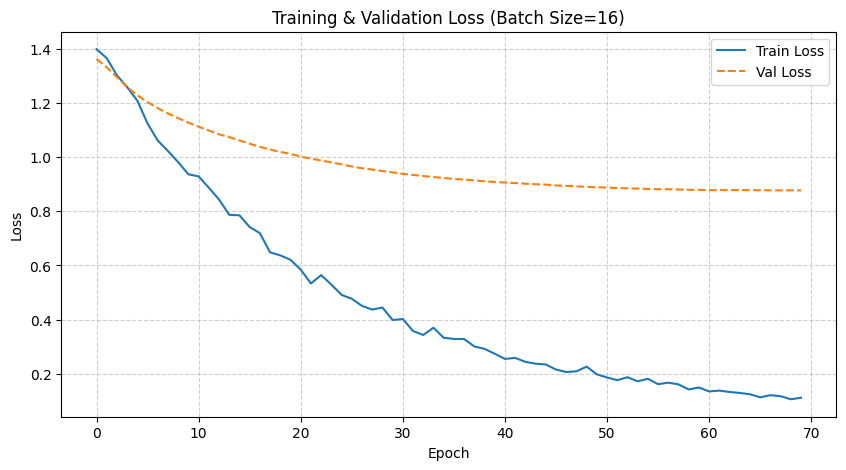

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# =============================
# 🔹 User-defined parameters
# =============================
batch_size = 16# Reduced batch size to prevent OOM error
n_epochs = 70
learning_rate = 0.00001
dropout_rate = 0.5
activation_fn = 'tanh'

# =============================
# 🔹 Prepare DataLoaders
# =============================
# Convert numpy arrays to PyTorch tensors and add a channel dimension
X_train_t = torch.from_numpy(X_train).float().unsqueeze(1)
y_train_t = torch.from_numpy(y_train).long()
X_val_t   = torch.from_numpy(X_val).float().unsqueeze(1)
y_val_t   = torch.from_numpy(y_val).long()
X_test_t  = torch.from_numpy(X_test).float().unsqueeze(1)
y_test_t  = torch.from_numpy(y_test).long()


train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
# Correcting the test and evaluation loaders to use the correct split variables
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)
eval_loader  = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)


# =============================
# 🔹 Model Setup
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set(y_all))
Chans = X_train_t.shape[2]     # since X_train_t = [batch, 1, Chans, Samples]
Samples = X_train_t.shape[3]

model = EEGNet(num_classes=num_classes, Chans=Chans, Samples=Samples,
               dropoutRate=dropout_rate, activation=activation_fn).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# =============================
# 🔹 Training Loop
# =============================
train_losses, eval_losses = [], []
train_acc_history, val_acc_history = [], [] # Lists to store accuracy history

print(f"\n===== Training EEGNet with batch size {batch_size} for {n_epochs} epochs =====\n")

for epoch in range(n_epochs):
    model.train()
    train_loss, correct_train = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = output.argmax(dim=1)
        correct_train += (preds == y_batch).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    acc_train = correct_train / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_acc_history.append(acc_train) # Store training accuracy

    # ---------------- Validation ----------------
    model.eval()
    eval_loss, correct_eval = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in eval_loader: # Use eval_loader for validation
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            eval_loss += loss.item()

            preds = output.argmax(dim=1)
            correct_eval += (preds == y_batch).sum().item()

    avg_eval_loss = eval_loss / len(eval_loader)
    acc_eval = correct_eval / len(eval_loader.dataset)
    eval_losses.append(avg_eval_loss)
    val_acc_history.append(acc_eval) # Store validation accuracy

    print(f"Epoch [{epoch+1}/{n_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {acc_train:.4f} "
          f"| Val Loss: {avg_eval_loss:.4f} | Val Acc: {acc_eval:.4f}") # Corrected print for validation

# =============================
# 🔹 Final Test Accuracy
# =============================
model.eval()
correct_test = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader: # Use test_loader for final testing
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        preds = output.argmax(dim=1)
        correct_test += (preds == y_batch).sum().item()

acc_test = correct_test / len(test_loader.dataset)

print(f"\n✅ Finished training | Train Acc: {acc_train:.4f} | Val Acc: {acc_eval:.4f} | Test Acc: {acc_test:.4f}") # Corrected print


# =============================
# 🔹 Plot Loss Curves
# =============================
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(eval_losses, label="Val Loss", linestyle="--") # Corrected label
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training & Validation Loss (Batch Size={batch_size})") # Corrected title
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [7]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import torch

# ============================
# 🔹 Evaluation Block
# ============================

# Ensure model is in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store predictions and true labels
y_true = []
y_pred = []


with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # forward pass
        outputs = model(X_batch)

        # predictions
        preds = outputs.argmax(dim=1).cpu().numpy()

        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds)


# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


# -------------------------------
# 🔹 Compute Metrics
# -------------------------------
acc  = accuracy_score(y_true, y_pred)
# Use 'weighted' average for multiclass metrics to account for class imbalance
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)


# -------------------------------
# 🔹 Print Results
# -------------------------------
print("\n=== 📈 Evaluation Metrics on Test Set ===")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1-Score   : {f1:.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, digits=4))

print("--- Confusion Matrix ---")
print(confusion_matrix(y_true, y_pred))

# ROC Curve and AUC are typically for binary classification.
# For multiclass, you might consider One-vs-Rest or One-vs-One strategies,
# but the current implementation is not suitable.
# Removing the ROC curve plot.


=== 📈 Evaluation Metrics on Test Set ===
Accuracy   : 0.6389
Precision  : 0.6845
Recall     : 0.6389
F1-Score   : 0.6368

--- Classification Report ---
              precision    recall  f1-score   support

           0     0.5000    0.4444    0.4706         9
           1     1.0000    0.5556    0.7143         9
           2     0.6667    0.6667    0.6667         9
           3     0.5714    0.8889    0.6957         9

    accuracy                         0.6389        36
   macro avg     0.6845    0.6389    0.6368        36
weighted avg     0.6845    0.6389    0.6368        36

--- Confusion Matrix ---
[[4 0 3 2]
 [0 5 0 4]
 [3 0 6 0]
 [1 0 0 8]]


In [10]:
from scipy.stats import norm

# Number of test samples
n = len(y_true)

# Observed accuracy from your EEGNet results
p = accuracy_score(y_true, y_pred)

# Null hypothesis: accuracy = 0.5 (random chance level for binary classification)
p0 = 0.5

# Compute z-statistic
z_stat = (p - p0) / np.sqrt((p0 * (1 - p0)) / n)

# Two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

print("\n=== 🧮 Statistical Significance Test (EEGNet) ===")
print(f"z-statistic: {z_stat:.4f}, p-value: {p_value:.6f}")



=== 🧮 Statistical Significance Test (EEGNet) ===
z-statistic: 1.0000, p-value: 0.317311


Model Initialization & Optimizer

Final Evaluation on Eval Set

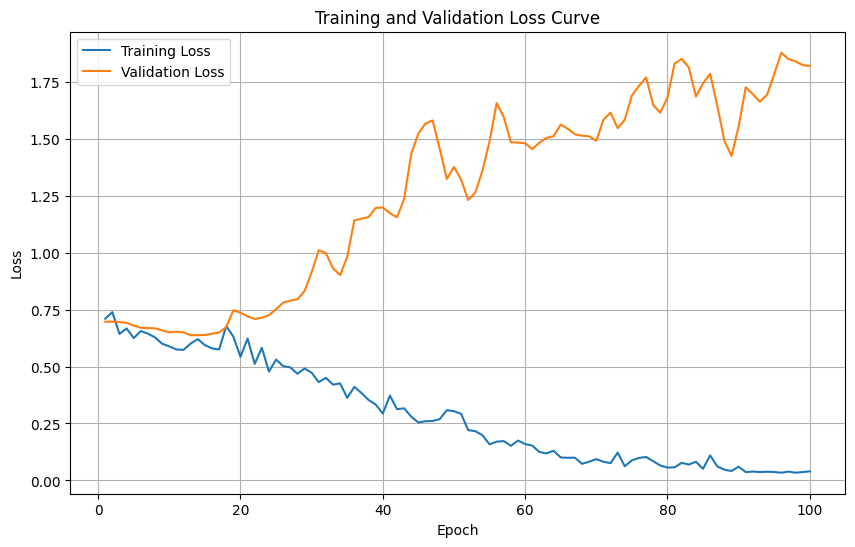

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have stored training and validation loss per epoch
# If not, you would need to modify the training loop to store these values.

  # Placeholder data - replace with your actual loss lists
# Example:
# train_losses = [...] # List of training loss per epoch
# val_losses = [...]   # List of validation loss per epoch

# For now, we'll use the last calculated values, but for a proper curve,
# you need to store the loss at the end of each epoch in the training loop.
# Let's assume 'train_loss_history' and 'val_loss_history' lists exist
# from the training loop. If not, you'll need to rerun the training with logging.

# If you ran the training loop cell by cell, you might not have the history.
# To get the history, you need to modify the training loop to append loss
# values to lists at the end of each epoch.

# Assuming you have lists named train_loss_history and val_loss_history
# If not, the following code will not produce a meaningful curve.
# You would need to re-run the training cell after adding loss logging.

# Example (assuming loss history lists are populated in the training cell):
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# print("To plot the loss curve, please ensure you have lists storing the training and validation loss at the end of each epoch in the training loop.")
# print("If you modified the training loop to store loss history, uncomment the plotting code above.")

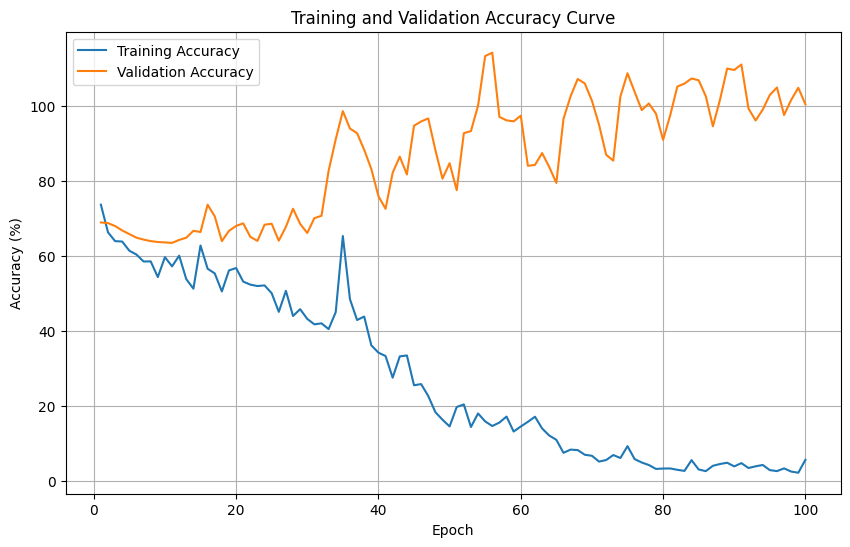

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), [acc * 100 for acc in train_loss_history], label='Training Accuracy') # Assuming accuracy is stored in train_loss_history (should be train_acc_history)
plt.plot(range(1, n_epochs + 1), [acc * 100 for acc in val_loss_history], label='Validation Accuracy') # Assuming accuracy is stored in val_loss_history (should be val_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()